In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import re
import ast
import matplotlib.pyplot as plt
from functools import reduce
from collections import Counter


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import time
import lightgbm as lgb
from math import sqrt


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('tmdb-box-office-prediction/train.csv')
test = pd.read_csv('tmdb-box-office-prediction/test.csv')

In [3]:
# Revising some wrong information
# based on https://www.kaggle.com/zero92/tmdb-prediction

def revise_info_train(train):
    
    train.loc[train['id'] == 16,'revenue'] = 192864         
    train.loc[train['id'] == 90,'budget'] = 30000000                  
    train.loc[train['id'] == 118,'budget'] = 60000000       
    train.loc[train['id'] == 149,'budget'] = 18000000       
    train.loc[train['id'] == 313,'revenue'] = 12000000       
    train.loc[train['id'] == 451,'revenue'] = 12000000      
    train.loc[train['id'] == 464,'budget'] = 20000000       
    train.loc[train['id'] == 470,'budget'] = 13000000       
    train.loc[train['id'] == 513,'budget'] = 930000         
    train.loc[train['id'] == 797,'budget'] = 8000000        
    train.loc[train['id'] == 819,'budget'] = 90000000       
    train.loc[train['id'] == 850,'budget'] = 90000000       
    train.loc[train['id'] == 1007,'budget'] = 2              
    train.loc[train['id'] == 1112,'budget'] = 7500000       
    train.loc[train['id'] == 1131,'budget'] = 4300000        
    train.loc[train['id'] == 1359,'budget'] = 10000000       
    train.loc[train['id'] == 1542,'budget'] = 1             
    train.loc[train['id'] == 1570,'budget'] = 15800000       
    train.loc[train['id'] == 1571,'budget'] = 4000000        
    train.loc[train['id'] == 1714,'budget'] = 46000000       
    train.loc[train['id'] == 1721,'budget'] = 17500000       
    train.loc[train['id'] == 1865,'revenue'] = 25000000      
    train.loc[train['id'] == 1885,'budget'] = 12             
    train.loc[train['id'] == 2091,'budget'] = 10             
    train.loc[train['id'] == 2268,'budget'] = 17500000       
    train.loc[train['id'] == 2491,'budget'] = 6              
    train.loc[train['id'] == 2602,'budget'] = 31000000       
    train.loc[train['id'] == 2612,'budget'] = 15000000       
    train.loc[train['id'] == 2696,'budget'] = 10000000      
    train.loc[train['id'] == 2801,'budget'] = 10000000       
    train.loc[train['id'] == 335,'budget'] = 2 
    train.loc[train['id'] == 348,'budget'] = 12
    train.loc[train['id'] == 470,'budget'] = 13000000 
    train.loc[train['id'] == 513,'budget'] = 1100000
    train.loc[train['id'] == 640,'budget'] = 6 
    train.loc[train['id'] == 696,'budget'] = 1
    train.loc[train['id'] == 797,'budget'] = 8000000 
    train.loc[train['id'] == 850,'budget'] = 1500000
    train.loc[train['id'] == 1199,'budget'] = 5 
    train.loc[train['id'] == 1282,'budget'] = 9              
    train.loc[train['id'] == 1347,'budget'] = 1
    train.loc[train['id'] == 1755,'budget'] = 2
    train.loc[train['id'] == 1801,'budget'] = 5
    train.loc[train['id'] == 1918,'budget'] = 592 
    train.loc[train['id'] == 2033,'budget'] = 4
    train.loc[train['id'] == 2118,'budget'] = 344 
    train.loc[train['id'] == 2252,'budget'] = 130
    train.loc[train['id'] == 2256,'budget'] = 1 
    train.loc[train['id'] == 2696,'budget'] = 10000000
    return train

def revise_info_test(test):
    test.loc[test['id'] == 3033,'budget'] = 250 
    test.loc[test['id'] == 3051,'budget'] = 50
    test.loc[test['id'] == 3084,'budget'] = 337
    test.loc[test['id'] == 3224,'budget'] = 4  
    test.loc[test['id'] == 3594,'budget'] = 25  
    test.loc[test['id'] == 3619,'budget'] = 500  
    test.loc[test['id'] == 3831,'budget'] = 3  
    test.loc[test['id'] == 3935,'budget'] = 500  
    test.loc[test['id'] == 4049,'budget'] = 995946 
    test.loc[test['id'] == 4424,'budget'] = 3  
    test.loc[test['id'] == 4460,'budget'] = 8  
    test.loc[test['id'] == 4555,'budget'] = 1200000 
    test.loc[test['id'] == 4624,'budget'] = 30 
    test.loc[test['id'] == 4645,'budget'] = 500 
    test.loc[test['id'] == 4709,'budget'] = 450 
    test.loc[test['id'] == 4839,'budget'] = 7
    test.loc[test['id'] == 3125,'budget'] = 25 
    test.loc[test['id'] == 3142,'budget'] = 1
    test.loc[test['id'] == 3201,'budget'] = 450
    test.loc[test['id'] == 3222,'budget'] = 6
    test.loc[test['id'] == 3545,'budget'] = 38
    test.loc[test['id'] == 3670,'budget'] = 18
    test.loc[test['id'] == 3792,'budget'] = 19
    test.loc[test['id'] == 3881,'budget'] = 7
    test.loc[test['id'] == 3969,'budget'] = 400
    test.loc[test['id'] == 4196,'budget'] = 6
    test.loc[test['id'] == 4221,'budget'] = 11
    test.loc[test['id'] == 4222,'budget'] = 500
    test.loc[test['id'] == 4285,'budget'] = 11
    test.loc[test['id'] == 4319,'budget'] = 1
    test.loc[test['id'] == 4639,'budget'] = 10
    test.loc[test['id'] == 4719,'budget'] = 45
    test.loc[test['id'] == 4822,'budget'] = 22
    test.loc[test['id'] == 4829,'budget'] = 20
    test.loc[test['id'] == 4969,'budget'] = 20
    test.loc[test['id'] == 5021,'budget'] = 40 
    test.loc[test['id'] == 5035,'budget'] = 1 
    test.loc[test['id'] == 5063,'budget'] = 14 
    test.loc[test['id'] == 5119,'budget'] = 2 
    test.loc[test['id'] == 5214,'budget'] = 30 
    test.loc[test['id'] == 5221,'budget'] = 50 
    test.loc[test['id'] == 4903,'budget'] = 15
    test.loc[test['id'] == 4983,'budget'] = 3
    test.loc[test['id'] == 5102,'budget'] = 28
    test.loc[test['id'] == 5217,'budget'] = 75
    test.loc[test['id'] == 5224,'budget'] = 3 
    test.loc[test['id'] == 5469,'budget'] = 20 
    test.loc[test['id'] == 5840,'budget'] = 1 
    test.loc[test['id'] == 5960,'budget'] = 30
    test.loc[test['id'] == 6506,'budget'] = 11 
    test.loc[test['id'] == 6553,'budget'] = 280
    test.loc[test['id'] == 6561,'budget'] = 7
    test.loc[test['id'] == 6582,'budget'] = 218
    test.loc[test['id'] == 6638,'budget'] = 5
    test.loc[test['id'] == 6749,'budget'] = 8 
    test.loc[test['id'] == 6759,'budget'] = 50 
    test.loc[test['id'] == 6856,'budget'] = 10
    test.loc[test['id'] == 6858,'budget'] =  100
    test.loc[test['id'] == 6876,'budget'] =  250
    test.loc[test['id'] == 6972,'budget'] = 1
    test.loc[test['id'] == 7079,'budget'] = 8000000
    test.loc[test['id'] == 7150,'budget'] = 118
    test.loc[test['id'] == 6506,'budget'] = 118
    test.loc[test['id'] == 7225,'budget'] = 6
    test.loc[test['id'] == 7231,'budget'] = 85
    test.loc[test['id'] == 5222,'budget'] = 5
    test.loc[test['id'] == 5322,'budget'] = 90
    test.loc[test['id'] == 5350,'budget'] = 70
    test.loc[test['id'] == 5378,'budget'] = 10
    test.loc[test['id'] == 5545,'budget'] = 80
    test.loc[test['id'] == 5810,'budget'] = 8
    test.loc[test['id'] == 5926,'budget'] = 300
    test.loc[test['id'] == 5927,'budget'] = 4
    test.loc[test['id'] == 5986,'budget'] = 1
    test.loc[test['id'] == 6053,'budget'] = 20
    test.loc[test['id'] == 6104,'budget'] = 1
    test.loc[test['id'] == 6130,'budget'] = 30
    test.loc[test['id'] == 6301,'budget'] = 150
    test.loc[test['id'] == 6276,'budget'] = 100
    test.loc[test['id'] == 6473,'budget'] = 100
    test.loc[test['id'] == 6842,'budget'] = 30
    return test

In [4]:
# adding external features kamalchhirang from kernel https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat by kamalchhirang

# https://www.kaggle.com/kamalchhirang/tmdb-competition-additional-features/

# Extra features
extra_data_train = pd.read_csv('tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
extra_data_test = pd.read_csv('tmdb-competition-additional-features/TestAdditionalFeatures.csv')
extra_data_train.head(1)


,imdb_id,popularity2,rating,totalVotes
0,tt0169547,16.217,8.0,6016.0


In [5]:
def merge_extra_data(data, extra_data):
    data = pd.merge(data, extra_data, how='left', on=['imdb_id'])
    data['popularity2'] = data['popularity2'].fillna(data['popularity2'].mode()[0])
    data['rating'] = data['rating'].fillna(data['rating'].mode()[0])
    data['totalVotes'] = data['totalVotes'].fillna(data['totalVotes'].mode()[0])
    return data

### Data exploration

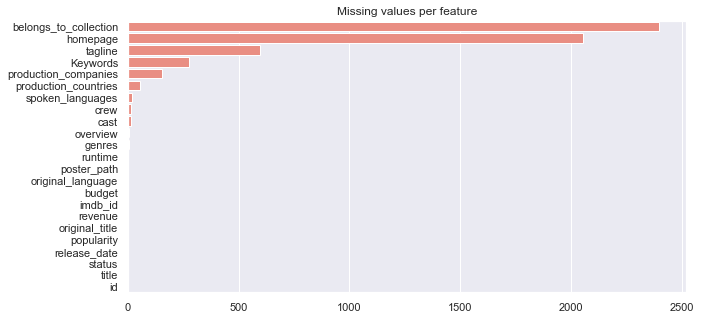

In [6]:
# Missing data per feature
series = data.isnull().sum().sort_values(ascending=False)
sns.set()
fig, ax = plt.subplots(figsize=[10,5])
g = sns.barplot(x=series.values, y=series.index, ax=ax, color='salmon')
g.set_title('Missing values per feature');

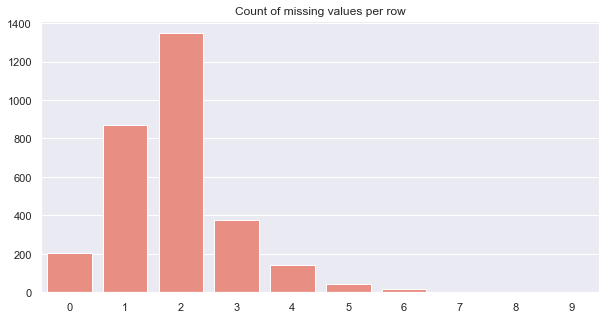

In [7]:
# Missing data per row
series = data.isnull().sum(axis=1).value_counts(ascending=False)
sns.set()
fig, ax = plt.subplots(figsize=[10,5])
g = sns.barplot(y=series.values, x=series.index, ax=ax, color='salmon',ci=None)
g.set_title('Count of missing values per row');

In [8]:
data.revenue.describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

### Analysis of top 200 movies with highest revenue

In [9]:
# 25% of highest revenue movies are above 68000000-> top_movies
top_movies = data.iloc[data.query('revenue>68000000').revenue.sort_values(ascending=False).index][:500]

In [10]:
# deal with object data
top_movies['belongs_to_collection'] = top_movies.belongs_to_collection.apply(lambda x: 1 if x is not np.nan else 0)
top_movies['cast'] = top_movies['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['crew'] = top_movies['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['Keywords'] = top_movies['Keywords'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['production_countries'] = top_movies['production_countries'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['production_companies'] = top_movies['production_companies'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['genres'] = top_movies['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
top_movies['genres_size'] = top_movies['genres'].apply(lambda x: len(x))

In [11]:
# Get genres of top movies
all_top_genres = []
top_movies['genres'].apply(lambda x: all_top_genres.append(x))

all_top_genres = reduce(lambda x,y: x + y, all_top_genres)
c = Counter(all_top_genres)
top_genres = dict(c)

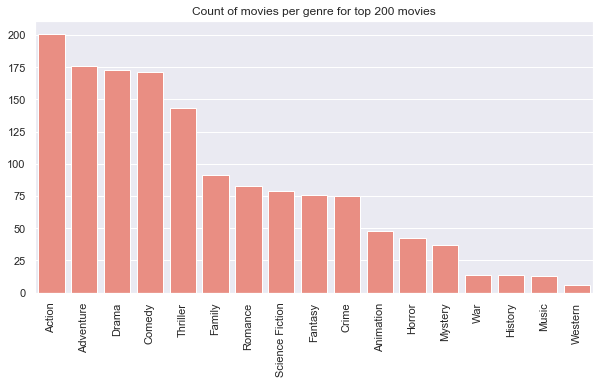

In [12]:
# Number of movies per genre for Top movies
import operator
from collections import OrderedDict

sorted_x = sorted(top_genres.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict = OrderedDict(sorted_x)

y = list(sorted_dict.keys())
x = list(sorted_dict.values())
sns.set()
fig, ax = plt.subplots(figsize=[10,5])
g = sns.barplot(x=y, y=x, ax=ax, color='salmon',ci=None)
g.set_title('Count of movies per genre for top 200 movies');
g.set_xticklabels(g.get_xticklabels(),rotation=90);

In [13]:
top_movies['month'] = data['release_date'].apply(lambda x: str(x).split('/')[0] if x is not np.nan else np.nan)
top_movies['year'] = data['release_date'].apply(lambda x: str(x).split('/')[2] if x is not np.nan else np.nan)
top_movies['year'] = top_movies['year'].apply(lambda x: '19'+x if int(x) > 30 and int(x)<100 else '20'+x)
top_movies['month'] = top_movies['month'].apply(int)
top_movies['year'] = top_movies['year'].apply(int)

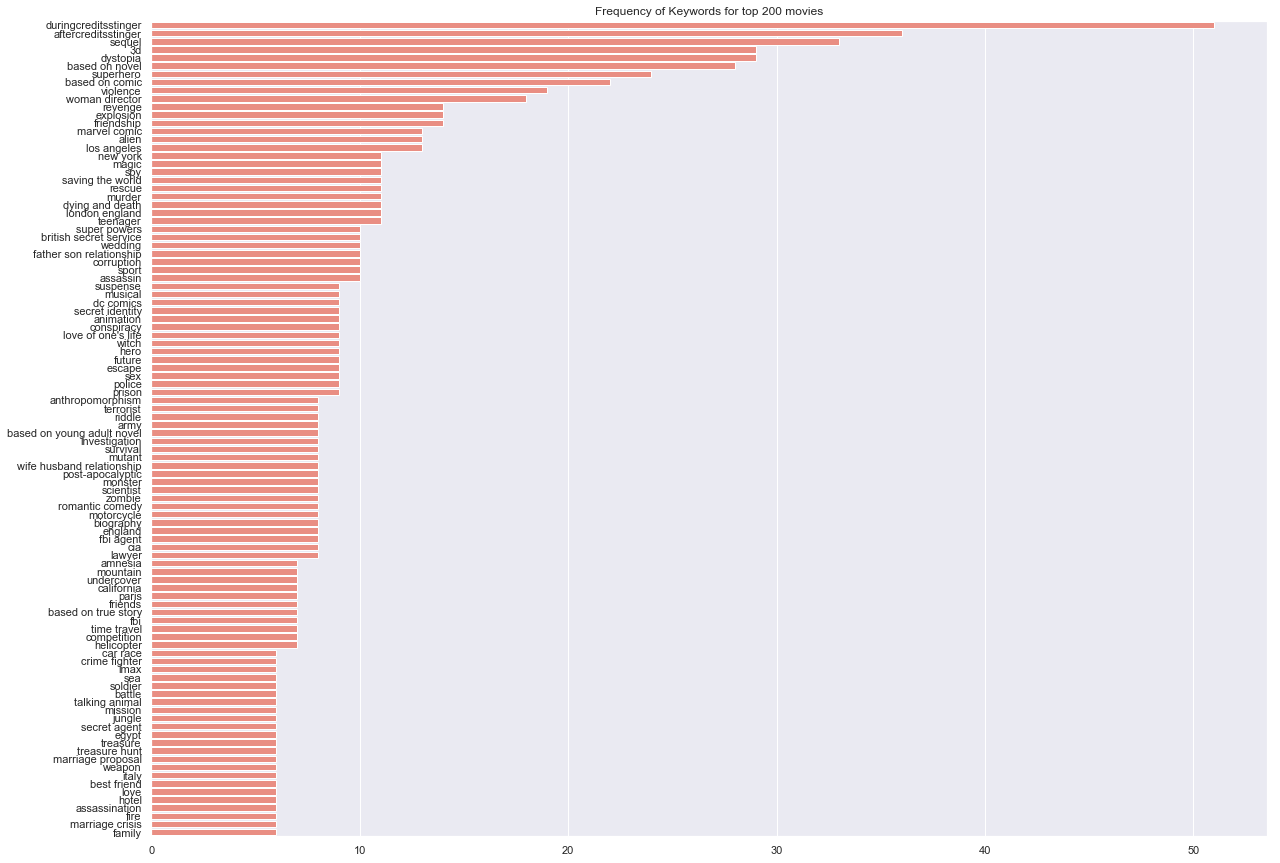

In [14]:
# Get keywords for top highest revenue movies
keywords = []
top_movies.Keywords.apply(lambda x: keywords.append(x));
keywords = reduce((lambda x, y: x + y), keywords)

# Get Keywords for top_movies
from nltk.probability import FreqDist
fdist_keywords = FreqDist(keywords)
labels = []
counts=[]
for word, freq in fdist_keywords.most_common(100):
    labels.append(word)
    counts.append(freq)
    
y = labels
x = counts
sns.set()
fig, ax = plt.subplots(figsize=[20,15])
g = sns.barplot(x=x, y=y, ax=ax, color='salmon',ci=None)
g.set_title('Frequency of Keywords for top 200 movies');

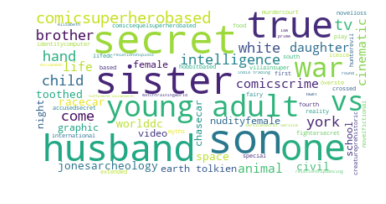

<Figure size 10800x10800 with 0 Axes>

In [15]:
from os import path
from PIL import Image
from wordcloud import WordCloud


text = ''.join(keywords)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig = plt.figure(figsize=(150, 150))
plt.show()

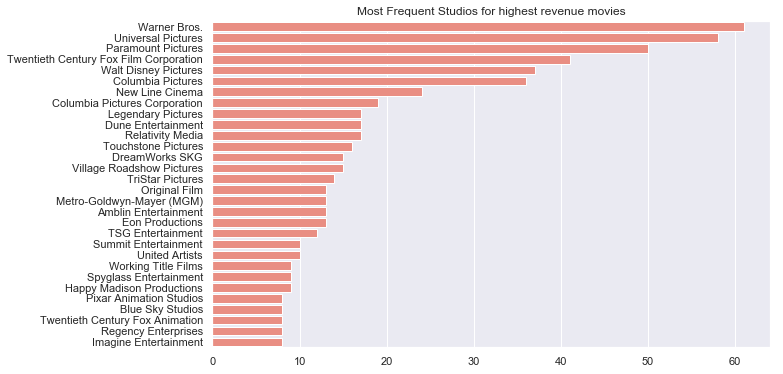

In [16]:
# Get Studio of Top Movies

studios = []
top_movies.production_companies.apply(lambda x: studios.append(x));
studios = reduce((lambda x, y: x + y), studios)

# count most frequent studios
fdist = FreqDist(studios)
labels = []
counts=[]

for word, freq in fdist.most_common(30):
    labels.append(word)
    counts.append(freq)

    
top_studios = []
top_studios = labels
    
y = labels
x = counts
sns.set()
fig, ax = plt.subplots(figsize=[10,6])
g = sns.barplot(x=x, y=y, ax=ax, color='salmon',ci=None)
g.set_title('Most Frequent Studios for highest revenue movies');

In [17]:
# Get Actors of Top Movies
actors = []
top_movies.cast.apply(lambda x: actors.append(x));
actors = reduce((lambda x, y: x + y), actors)
print(len(actors))
# count most frequent studios
fdist = FreqDist(actors)
labels = []
counts=[]

for word, freq in fdist.most_common(500):
    labels.append(word)
    counts.append(freq)
    
print(labels)
top_actors = labels

15600
['Sylvester Stallone', 'Samuel L. Jackson', 'Tom Hanks', 'Stanley Tucci', 'Ian McKellen', 'Hugo Weaving', 'John Ratzenberger', 'Desmond Llewelyn', 'Frank Welker', 'Judi Dench', 'Morgan Freeman', 'Sean Bean', 'Tom Cruise', 'Philip Ettington', 'Patrick Stewart', 'Arnold Schwarzenegger', 'Mel Gibson', 'Jeremy Renner', 'Stan Lee', 'Vin Diesel', 'Shia LaBeouf', 'Alan Tudyk', 'Jess Harnell', 'Gary Oldman', 'Jim Broadbent', 'Bradley Cooper', 'Harrison Ford', 'Liam Neeson', 'George Clooney', 'Mark Wahlberg', 'Adam Sandler', 'Hugh Jackman', 'John Michael Higgins', 'Jason Statham', 'Andy Serkis', 'John Malkovich', 'Ken Jeong', 'Johnny Depp', 'Bill Hader', 'Sigourney Weaver', 'Christopher Lee', 'Elijah Wood', 'Michael Caine', 'James Earl Jones', 'Jim Cummings', 'John C. Reilly', 'Michael Madsen', 'Ed Harris', 'Jonah Hill', 'John Goodman', 'Owen Wilson', 'Jack Black', 'Brad Pitt', 'Jamie Foxx', 'Halle Berry', 'Marisa Tomei', 'Julia Roberts', 'Hugh Grant', 'Jim Carrey', 'Bruce Willis', 'Eddie

In [18]:
# Get Directors of top movies

# create feature director
data['director'] = data['crew'].apply(lambda x: [i['name'] if i['job']=='Director' else '' for i in ast.literal_eval(x)] if x is not np.nan else '').apply(lambda x: ''.join(x))

# get top movies
top_movies = data.iloc[data.query('revenue>68000000').revenue.sort_values(ascending=False).index][:200]

# Get directors of Top Movies
directors = []
top_movies.director.apply(lambda x: directors.append(x))
directors = list(filter(lambda x: x != '', directors))

# count most frequent studios
fdist = FreqDist(directors)
labels = []
counts=[]

for word, freq in fdist.most_common(50):
    labels.append(word)
    counts.append(freq)
    
print(labels)
top_directors = labels

['Steven Spielberg', 'Michael Bay', 'Peter Jackson', 'Brett Ratner', 'James Wan', 'Carlos Saldanha', 'Ridley Scott', 'Martin Campbell', 'M. Night Shyamalan', 'Ron Howard', 'Robert Zemeckis', 'Joss Whedon', 'Tim Burton', 'Christopher Nolan', 'Gore Verbinski', 'Sam Mendes', 'Chris Columbus', 'James Gunn', 'George Lucas', 'Andrew Adamson', 'Chris Weitz', 'Brad Bird', 'Francis Lawrence', 'Marc Forster', 'Andrew Stanton', 'Todd Phillips', 'Jon Turteltaub', 'Bryan Singer', 'George Miller', 'Chris Wedge', 'Nancy Meyers', 'Darren Aronofsky', 'Tony Scott', 'Paul Verhoeven', 'Wolfgang Petersen', 'Paul W.S. Anderson', 'Sylvester Stallone', 'Bill Condon', 'Rob Marshall', 'Andrew StantonAngus MacLane', 'Byron HowardRich MooreJared Bush', 'David Yates', 'Roger AllersRob Minkoff', 'Tim Miller', 'Robert Stromberg', 'Alfonso Cuar√≥n', 'Anthony RussoJoe Russo', 'David Slade', 'Zack Snyder', 'Mel Gibson']


### Plot correlation between features

In [19]:
# Engineer new features based on actors, studios and genre
# data was not transformed until here

# deal with object data
data['cast'] = data['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
data['crew'] = data['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
data['production_countries'] = data['production_countries'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
data['production_companies'] = data['production_companies'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
data['have_keyword'] = data['Keywords'].apply(lambda x: [1 if i['name'] in keywords else 0 for i in ast.literal_eval(x)] if x is not np.nan else []).apply(lambda x: np.sign(sum(x)))

# Engineer features based on crew, cast and studios len

data['cast_size'] = data['cast'].apply(lambda x: len(x))
data['crew_size'] = data['crew'].apply(lambda x: len(x))
data['studios_size'] = data['production_companies'].apply(lambda x: len(x))
data['genres_size'] = data['genres'].apply(lambda x: ast.literal_eval(x) if x is not np.nan else np.nan).apply(lambda x: len(x) if x is not np.nan else 0)
data['genres'] = data['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])

# Engineer features based on actor, directors, studios
# if member of cast/crew/director belong to top_directors/top_actors/top_cast then 1 else 0

data['top_cast'] = data['cast'].apply(lambda x: [1 if i in top_actors else 0 for i in x]).apply(lambda x: np.sign(sum(x)))
data['top_studios'] = data['production_companies'].apply(lambda x: [1 if i in top_studios else 0 for i in x]).apply(lambda x: np.sign(sum(x)))
data['top_directors'] = data['director'].apply(lambda x: 1 if x in directors else 0)

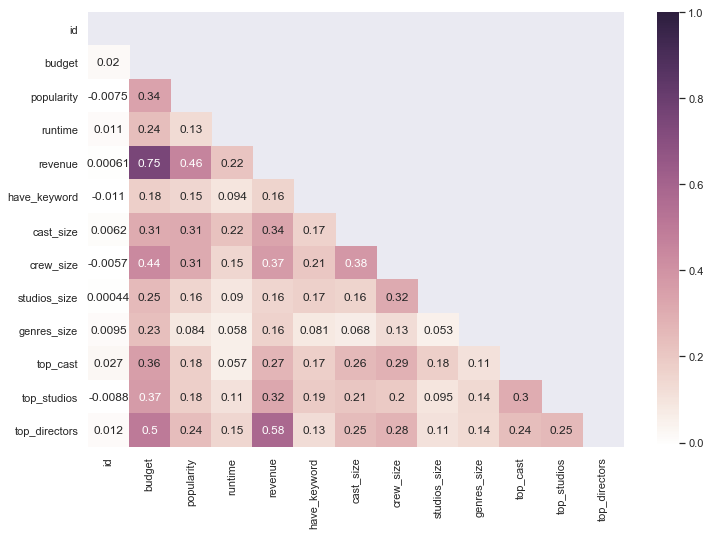

In [20]:
# Plot correlations

fig, ax = plt.subplots(figsize=[12,8])
#data = data.drop(columns=['id'])
cor=data.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, 
            annot=True, cmap=cmap,mask=mask);

### Prepare data 

In [21]:
# Before run prepare_data the following lists must be filled(prev cells must be run)
# directors, top_studios, top_actors

In [22]:
def prepare_data(data):
    
    # gender features
    mapped_gender = data['cast'].apply(lambda x: [i['gender'] for i in ast.literal_eval(x)] if x is not np.nan else [])
    data['gender2'] = mapped_gender.apply(lambda x: Counter(x).get(2,0))
    data['gender1'] = mapped_gender.apply(lambda x: Counter(x).get(1,0))
    
    # Engineer new feature relating homepage and franchise
    df_collection_bool = data.belongs_to_collection.apply(lambda x: 1 if x is not np.nan else 0)
    df_homepage_bool = data.homepage.apply(lambda x: 1 if x is not np.nan else 0)
    
    data['factor'] = df_collection_bool & df_homepage_bool

    # Deal with object data
    data['director'] = data['crew'].apply(lambda x: [i['name'] if i['job']=='Director' else '' for i in ast.literal_eval(x)] if x is not np.nan else '').apply(lambda x: ''.join(x))
    data['cast'] = data['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
    data['crew'] = data['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
    data['production_countries'] = data['production_countries'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
    data['production_companies'] = data['production_companies'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])
    data['have_keyword'] = data['Keywords'].apply(lambda x: [1 if i['name'] in keywords else 0 for i in ast.literal_eval(x)] if x is not np.nan else []).apply(lambda x: np.sign(sum(x)))
    data['genres'] = data['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if x is not np.nan else [])

    # Engineer features based on crew, cast and studios len
    data['cast_size'] = data['cast'].apply(lambda x: len(x))
    data['crew_size'] = data['crew'].apply(lambda x: len(x))
    data['studios_size'] = data['production_companies'].apply(lambda x: len(x))

    # Engineer features based on actor, directors, studios

    data['top_cast'] = data['cast'].apply(lambda x: [1 if i in top_actors else 0 for i in x]).apply(lambda x: sum(x))   
    data['top_studios'] = data['production_companies'].apply(lambda x: [1 if i in top_studios else 0 for i in x]).apply(lambda x: sum(x))
    data['top_directors'] = data['director'].apply(lambda x: 1 if x in directors else 0)

    # Create 2 new columns month and year   
    data['month'] = data['release_date'].apply(lambda x: str(x).split('/')[0] if x is not np.nan else np.nan)
    data['year'] = data['release_date'].apply(lambda x: str(x).split('/')[2] if x is not np.nan else np.nan)
    
    # Create feature related to quantity of genres
    data['genres_size'] = data['genres'].apply(lambda x: len(x) if x is not np.nan else 0)
    
    # Fill missing values
    data['overview'] = data.overview.fillna('')
    data['tagline'] = data.tagline.fillna('')
    data['runtime'] = data.runtime.fillna(data.runtime.mode()[0])
    data['month'] = data.month.fillna(data.month.mode()[0])
    data['year'] = data.year.fillna(data.year.mode()[0])
    
    # Correct year to have 4digits
    data['year'] = data['year'].apply(lambda x: '19'+x if int(x) > 30 and int(x)<100 else '20'+x)
    data['month'] = data['month'].apply(int)
    data['year'] = data['year'].apply(int)
    
    # original language
    data['isEnglish'] = data.original_language.apply(lambda x: 1 if x == 'en' else 0)
    
    # new features
    data['crew_size'] = data.crew_size.replace({0:data.crew_size.mean()})
    data['cast_size'] = data.cast_size.replace({0:data.cast_size.mean()})
    
    data['budget'] = data.budget.replace({0:data.budget.mean()})
    
    data['diff_popularity'] = abs(data['popularity2']-data['popularity'])
    
    data['ratio_crew_cast'] = data['crew_size'] /(data['cast_size']+0.1)


    data['norm_rating'] = (data.rating - data.rating.min())/(data.rating.max() - data.rating.min())

    data['norm_totalVotes'] = (data.totalVotes - data.totalVotes.min())/(data.totalVotes.max() - data.totalVotes.min())

    data['norm_popularity'] = (data.popularity - data.popularity.min())/(data.popularity.max() - data.popularity.min())

    data['norm_popularity2'] = (data.popularity2 - data.popularity2.min())/(data.popularity2.max() - data.popularity2.min())

    data['norm_ratio_rating'] = data['norm_rating'] / (data['norm_totalVotes']+0.1)
    
    data['norm_ratio_pop'] = data['norm_popularity'] / (data['norm_popularity2']+0.1)
    
    # Drop columns
    drop_columns = ['belongs_to_collection','homepage','poster_path', 'spoken_languages',
                    'status','crew','imdb_id','release_date', 
                    'title','overview','tagline','title','Keywords','original_title',
                    'cast','id','director']

    data = data.drop(columns=drop_columns)
    return data

In [23]:
data = pd.read_csv('tmdb-box-office-prediction/train.csv')
data = merge_extra_data(data, extra_data_train)
data = revise_info_train(data)
processed_data = prepare_data(data)

In [24]:
test = pd.read_csv('tmdb-box-office-prediction/test.csv')
test = merge_extra_data(test, extra_data_test)
test = revise_info_test(test)
processed_test = prepare_data(test)

### Encoding genres

In [29]:
# Counting categorical feature levels

# Count levels for genres feature 
all_genres = []
processed_data['genres'].apply(lambda x: all_genres.append(x))
processed_test['genres'].apply(lambda x: all_genres.append(x))

all_genres = reduce(lambda x,y: x + y, all_genres)
c = Counter(all_genres)
genres = dict(c)
print('# of genres:', len(genres))

# Count levels for production_companies feature
all_prod_countries = []
processed_data['production_countries'].apply(lambda x: all_prod_countries.append(x))
processed_test['production_countries'].apply(lambda x: all_prod_countries.append(x))

all_prod_countries = reduce(lambda x,y: x + y, all_prod_countries)
c = Counter(all_prod_countries)
production_countries = dict(c)
print('# of prod countries:', len(production_countries))

# Count levels for production_companies feature
all_prod_companies = []
processed_data['production_companies'].apply(lambda x: all_prod_companies.append(x))
processed_test['production_companies'].apply(lambda x: all_prod_companies.append(x))

all_prod_companies = reduce(lambda x,y: x + y, all_prod_companies)
c = Counter(all_prod_companies)
production_companies = dict(c)

print('# of prod companies:', len(production_companies))

# of genres: 20
# of prod countries: 98
# of prod companies: 7087


The feature genres has different levels on train and test data ('TV Movie'is present only in train data), then when using pd.get_dummies() I got an error. 
To solve this problem, I got all genres in train and test set in a list, then create and fill
the columns with levels of 'genres' using get_genres_encoded(data)

In [31]:
# Get all genres
all_genres = list(genres.keys())

In [ ]:
# 1) perhaps sklearn.preprocessing MultiLabelBinarizer?
# 2) using pd.get_dummies, didnt work
    #s = data['genres'] # each elem is a list
    #data = data.join(pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0))

In [32]:
# use all_genres list filled in prev cell

def get_genres_encoded(data): 
    
    df_genres = pd.DataFrame(0, index=np.arange(len(data)), columns=all_genres)
    data['mapped_genres'] = data['genres'].apply(lambda y: list(map(lambda x: 1 if x in y else 0 ,all_genres)))

    for idx, feat in enumerate(all_genres):
        col = data['mapped_genres'].apply(lambda x: x[idx]).values
        df_genres[feat] = col

    return df_genres


def one_hot_encode(data):
    data = data.join(get_genres_encoded(data))
    
    # remove original column
    data = data.drop(columns=['genres','production_countries','original_language',
                            'production_companies','mapped_genres'])
    
    return data


In [34]:
processed_data = one_hot_encode(processed_data)
processed_data.head(1)

,budget,popularity,runtime,revenue,popularity2,rating,totalVotes,gender2,gender1,factor,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,14000000.0,6.575393,93.0,12314651,10.4,5.0,482.0,10,8,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
processed_test = one_hot_encode(processed_test)
processed_test.head(1)

,budget,popularity,runtime,popularity2,rating,totalVotes,gender2,gender1,factor,have_keyword,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,2.259957e+07,3.851534,90.0,6.468,6.6,91.0,0,3,1,0,...,0,0,0,0,0,1,0,0,0,0


### Analyze skewed features

In [270]:
# Check distribution of features: budget, popularity, runtime

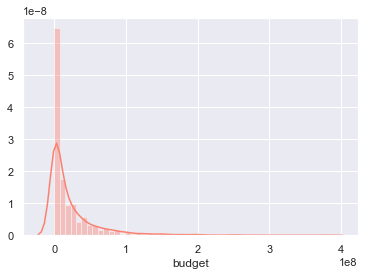

In [173]:
# 1. check if budget has a skewed distribution, if it has apply logarithmic transformation
sns.distplot(processed_data.budget, color='salmon');


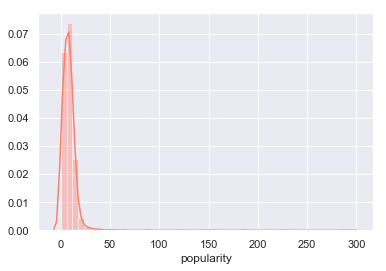

In [174]:
# 2. check popularity distribution
sns.distplot(processed_data['popularity'], color='salmon');

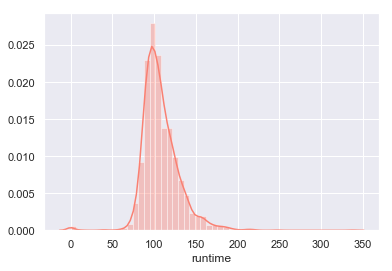

In [175]:
# 3. check runtime distribution
sns.distplot(processed_data['runtime'], color='salmon');

In [36]:
# it is a right skewed distribution, apply log transform
def apply_log_transform(data, skewed):
    
    data[skewed] = np.log1p(data[skewed])
    
    return data

In [37]:
skewed = ['budget', 'popularity']
processed_data = apply_log_transform(processed_data, skewed)
processed_data.head(1)

,budget,popularity,runtime,revenue,popularity2,rating,totalVotes,gender2,gender1,factor,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,16.454568,2.024905,93.0,12314651,10.4,5.0,482.0,10,8,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
skewed = ['budget', 'popularity']
processed_test = apply_log_transform(processed_test, skewed)
processed_test.head(1)

,budget,popularity,runtime,popularity2,rating,totalVotes,gender2,gender1,factor,have_keyword,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,16.933441,1.579295,90.0,6.468,6.6,91.0,0,3,1,0,...,0,0,0,0,0,1,0,0,0,0


### Model

In [43]:
# Training model
y = processed_data['revenue']
X = processed_data.drop(columns=['revenue'])
y = np.log1p(y)
X.head(2)


,budget,popularity,runtime,popularity2,rating,totalVotes,gender2,gender1,factor,have_keyword,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,16.454568,2.024905,93.0,10.400,5.0,482.0,10,8,0,1,...,0,0,0,0,0,0,0,0,0,0
1,17.504390,2.224504,113.0,15.229,6.4,1528.0,10,10,0,1,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Scale data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X);
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [45]:
# does not scale
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

#### XGB model

In [46]:
xgb_params = {'objective': 'reg:linear',
              'max_depth': 5,
              'min_child_weight': 3,
              'subsample': 0.9,
              'colsample_bytree': 0.4,
              'eval_metric': 'rmse',
              'seed': 11,
              'reg_lambda': 2.5,
              'learning_rate': 0.01,
              'n_estimators': 3000
 }
# without early stopping
#reg = xgb.XGBRegressor(**xgb_params)
#reg.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train, 
             early_stopping_rounds=200, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

# predict values
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

print(sqrt(mean_squared_error(y_valid , y_valid_pred)))

/usr/local/lib/python3.7/site-packages/xgboost-0.83.dev0-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.780189565516259


#### LGB model

In [47]:
lgb_params = {
         'num_leaves': 25,
         'max_depth': 4,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'learning_rate': 0.04,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l2": 2.25,
         "verbosity": -1,
        'min_sum_hessian_in_leaf': 11
         }

lgb_model = lgb.LGBMRegressor(**lgb_params, n_estimators = 10000, nthread =4, n_jobs = -1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_metric='rmse', verbose=1000, early_stopping_rounds=200)


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 1.46917	valid_1's rmse: 1.75592


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l2=2.25, learning_rate=0.04, max_depth=4, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
       min_split_gain=0.0, min_sum_hessian_in_leaf=11, n_estimators=10000,
       n_jobs=-1, nthread=4, num_leaves=25, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbosity=-1)

In [874]:
# predict values
y_train_pred = lgb_model.predict(X_train)
y_valid_pred = lgb_model.predict(X_valid)
print(sqrt(mean_squared_error(y_train , y_train_pred)))
print(sqrt(mean_squared_error(y_valid , y_valid_pred)))


1.3053902980274996
1.7444526664212054


In [875]:
import eli5 
eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.3186,totalVotes
0.2570,budget
0.0686,popularity2
0.0672,year
0.0582,top_studios
0.0353,runtime
0.0329,norm_ratio_rating
0.0199,popularity
0.0149,rating
0.0115,cast_size


### Test prediction

In [876]:
X_test = processed_test
X_test.columns
X_test.shape


(4398, 46)

In [836]:
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [877]:
y_test_pred_lgb = lgb_model.predict(X_test)

In [878]:
y_test_pred = np.exp(y_test_pred_lgb)
print(pd.DataFrame(y_test_pred).shape)
print(test.shape)

(4398, 1)
(4398, 46)


In [879]:
output = pd.DataFrame(test['id'])
output['revenue'] = y_test_pred
output = output.set_index('id')
output.head()


,revenue
id,
3001,4.554457e+06
3002,2.271693e+06
3003,2.219233e+07
3004,1.169804e+07
3005,1.557055e+06


In [880]:
output.to_csv("submission.csv")